# setup 

will try:

resnet: https://ctmakro.github.io/site/on_learning/resnet_keras.html

simplenet: https://arxiv.org/pdf/1608.06037.pdf

leaky relu: https://keras.io/layers/advanced-activations/

this site has desciptions for voting ensembles, cool: https://mlwave.com/kaggle-ensembling-guide/

in combinatio with my convolutional ensemble from before.

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices() 

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16051808429042431414, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 11332668621
 locality {
   bus_id: 2
 }
 incarnation: 9114287088415133347
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:84:00.0"]

In [2]:
import numpy as np
import pandas as pd

from scipy import ndimage
from scipy import misc

import os, gc, sys, glob
from tqdm import tqdm

from sklearn import model_selection
from sklearn import metrics

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Activation, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

from keras.applications.resnet50 import ResNet50

from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
DATA_DIR = os.path.join('/scratch', 'yns207', 'data_invasive')

path = DATA_DIR
test_path = os.path.join(path, 'test')
models_path = os.path.join(path, 'results')
train_path = os.path.join(path, 'train')
valid_path = os.path.join(path, 'valid')
model_name = 'model_jun24_kfold'
print(path)

/scratch/yns207/data_invasive


```
%cd $DATA_DIR
!module load centos/7
!7za x '*.7z'
```

# defining funcs

In [4]:
def grab_optimizer(opt, lr):
    if opt == 'sgd':
        return optimizers.SGD(lr=lr, decay=1e-6, momentum=0.8, nesterov=True)
    elif opt == 'adam':
        return optimizers.Adam(lr=lr)
    elif opt == 'adagrad':
        return optimizers.Adagrad(lr=lr)
    elif opt == 'rmsprop':
        return optimizers.RMSprop(lr=lr)

In [5]:
def dense_block(units, activation, drop_prob, inputs):
    x = BatchNormalization()(inputs)
    x = Dense(units, activation=activation)(x)
    x = Dropout(drop_prob)(x)
    return x

In [6]:
def resnet_identity_block(inputs, filters_size, filter_depths):
    x = Convolution2D(filter_depths[0], (1,1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Convolution2D(filter_depths[1], filters_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Convolution2D(filter_depths[2], (1,1))(x)
    x = BatchNormalization()(x)

    x = keras.layers.add([x, inputs])
    x = Activation('relu')(x)
    
    return x

In [7]:
def resnet_conv_block(inputs, fitler_size, filter_depths, strides):
    x = Convolution2D(filter_depths[0], (1,1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Convolution2D(filter_depths[1], fitler_size)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Convolution2D(filter_depths[2], (1,1))(x)
    x = BatchNormalization()(x)
    
    shortcut = Convolution2D(filter_depths[2], (1,1))(inputs)
    shortcut = BatchNormalization()(shortcut)
    
    x = keras.layers.add([x, shortcut])
    x = Activation('relu')(x)
    
    return x

In [8]:
def make_model_finetune(input_shape, optimizer):
    base_model = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    m = Flatten()(base_model.layers[-1].output)
    m = dense_block(2048, 'relu', 0.25, inputs=m)
    m = dense_block(512, 'relu', 0.5, inputs=m)
    outputs = dense_block(1, 'sigmoid', 0, inputs=m)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [9]:
def make_model(input_shape, optimizer):
    # setup the input to the resnet
    inputs = Input(shape=input_shape)
    x = ZeroPadding2D((3,3))(inputs)
    x = Convolution2D(32, (7,7), strides=(2,2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3,3), strides=(2,2))(x)
    
    x = resnet_conv_block(x, (3,3), [64, 64, 256], (1, 1))
    x = resnet_identity_block(x, 3, [64, 64, 256])
    
    x = resnet_conv_block(x, (3,3), [128, 128, 512], (2,2))
    x = resnet_identity_block(x, 3, [128, 128, 512])
    
    x = AveragePooling2D((7, 7))(x)
    
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [27]:
def conv_block(filter_depth, filter_size, pool_size, activation, inputs):
    x = BatchNormalization()(inputs)
    x = Convolution2D(filter_depth, filter_size, activation=activation)(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    return x

def dense_block(units, activation, drop_prob, inputs):
    x = BatchNormalization()(inputs)
    x = Dense(units, activation=activation)(x)
    x = Dropout(drop_prob)(x)
    return x

def make_model_22(input_shape, optimizer):
    inputs = Input(shape=input_shape)
    m = conv_block(16, (3,3), (2,2),'relu', inputs=inputs)
    m = conv_block(32, (3,3), (2,2), 'relu', inputs=m)
    m = conv_block(64, (3,3), (2,2), 'relu', inputs=m)
    m = conv_block(128, (3,3), (2,2), 'relu', inputs=m)
    m = Flatten()(m)
    m = dense_block(2048, 'relu', 0.55, inputs=m)
    m = dense_block(512, 'relu', 0.65, inputs=m)
    outputs = dense_block(1, 'sigmoid', 0, inputs=m)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [28]:
def conv_block(filter_depth, filter_size, pool_size, activation, inputs):
    x = BatchNormalization()(inputs)
    x = Convolution2D(filter_depth, filter_size, activation=activation)(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    return x

def dense_block(units, activation, drop_prob, inputs):
    x = BatchNormalization()(inputs)
    x = Dense(units, activation=activation)(x)
    x = Dropout(drop_prob)(x)
    return x

def make_model_23(input_shape, optimizer):
    inputs = Input(shape=input_shape)
    m = conv_block(16, (3,3), (2,2),'relu', inputs=inputs)
    m = conv_block(32, (3,3), (2,2), 'relu', inputs=m)
    m = conv_block(64, (3,3), (2,2), 'relu', inputs=m)
    m = conv_block(128, (3,3), (2,2), 'relu', inputs=m)
    m = conv_block(256, (3,3), (2,2), 'relu', inputs=m)
    m = Flatten()(m)
    m = dense_block(2048, 'relu', 0.25, inputs=m)
    m = dense_block(512, 'relu', 0.5, inputs=m)
    outputs = dense_block(1, 'sigmoid', 0, inputs=m)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [10]:
def make_preds(model, test_data):
    # worth leaving a note:
    # prediction 1,2,3 from jun21 had misalgined the test names
    # also submission file 3 and 4 for jun21 are actually both rubmission 4 (accident)
    preds = model.predict(test_data).flatten()
    subm = test_set.copy()
    subm['invasive'] = preds
    return subm

In [11]:
train_set = pd.read_csv(os.path.join(path, 'train_labels.csv'))
test_set = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

In [12]:
train_set.head(2)

,name,invasive
0,1,0
1,2,0


In [13]:
#img_shape should eb tuple
#(H,W), height, width
def read_img(img_path, img_shape):
    img = misc.imread(img_path)
    img = misc.imresize(img, img_shape)
    return img

In [14]:
def read_imgs(img_height, img_width):
    train_img, test_img = [],[]
    for img_path in tqdm(train_set['name'].iloc[:]):
        train_img.append(read_img(os.path.join(path, 'train', str(img_path)+'.jpg'), (img_height, img_width)))

    for img_path in tqdm(test_set['name'].iloc[:]):
        test_img.append(read_img(os.path.join(path, 'test', str(img_path)+'.jpg'), (img_height, img_width)))

    train_img = np.array(train_img, np.float32)/255
    test_img = np.array(test_img, np.float32)/255
    train_label = np.array(train_set['invasive'].iloc[:])
    
    return train_img, test_img, train_label

In [15]:
train_img, test_img, train_label = read_imgs(300,400)

100%|██████████| 1531/1531 [00:52<00:00, 29.08it/s]


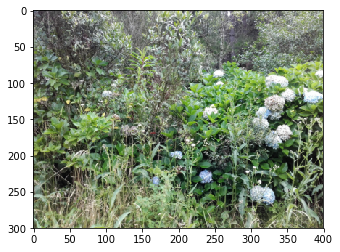

In [16]:
import matplotlib.pyplot as plt
plt.imshow(misc.imresize(train_img[124], (300,400)))
plt.show()

In [ ]:
%cd $DATA_DIR
def train_model_k_folds(model, train_data, train_label, model_out,  model_init_weights, epochs, kfolds):
    batch_size = 32
    kf = model_selection.KFold(n_splits=kfolds, shuffle=True)
    score_func = metrics.roc_auc_score

    i = 0
    models_stats = {}
    for train_ixs, valid_ixs in kf.split(train_data):
        x_train = train_data[train_ixs]
        x_valid = train_data[valid_ixs]
        y_train = train_label[train_ixs]
        y_valid = train_label[valid_ixs]

        gen = ImageDataGenerator(
            rotation_range = 30,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            vertical_flip = True,
            fill_mode = 'nearest')
        
        #re-initialzie the weights of the model on each run
        model.load_weights(model_init_weights)
        model_out_file = '/scratch/yns207/data_invasive/{}_{}.model'.format(model_out, str(i))
        model_checkpoint = ModelCheckpoint(model_out_file, 
                                            monitor='val_loss', 
                                            save_best_only=True)
        early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='auto')

        hist = model.fit_generator(gen.flow(x_train, y_train, batch_size=batch_size),
                            steps_per_epoch=(len(x_train)//batch_size)+1,
                            validation_data=(x_valid,y_valid),
                            validation_steps=(len(x_valid)//batch_size)+1,
                            epochs=epochs,
                            verbose=1,
                            callbacks=[early_stopping, model_checkpoint])
        
        model.load_weights(model_out_file)
        
        eval_tr = model.evaluate(x_train, y_train)
        eval_va = model.evaluate(x_valid, y_valid)
        
        tr_score = score_func(y_train, model.predict(x_train)[:, 0])
        va_score = score_func(y_valid, model.predict(x_valid)[:, 0])
        
        print('\n')
        print('kfold: {}'.format(str(i)))
        print('best model train acc: {}, loss: {}'.format(eval_tr[1], eval_tr[0]))
        print('best model valid acc: {}, loss: {}'.format(eval_va[1], eval_va[0]))
        print('best model train aroc score: {}, valid aroc score: {}'.format(tr_score, va_score))
        print('\n')
        models_stats[model_out_file] = {'score_tr_va':[tr_score, va_score], 'train_acc_loss':[eval_tr[1], eval_tr[0]], 'val_acc_loss':[eval_va[1], eval_va[0]]}
        i += 1
        
    return models_stats

/scratch/yns207/data_invasive


In [ ]:
# make a model
model = make_model_finetune((300,400,3), grab_optimizer('adam', 0.0005))
# save initial weights for use on each kfolds run
model.save_weights('{}_base.model'.format(model_name))
# run kfolds 10x
models_stats = train_model_k_folds(model, train_img, train_label, model_name, '{}_base.model'.format(model_name), 60, 10)

Epoch 1/60
65/65 [==============================] - 60s - loss: 0.4755 - acc: 0.8104 - val_loss: 1.6785 - val_acc: 0.3870
Epoch 2/60
65/65 [==============================] - 57s - loss: 0.3726 - acc: 0.8535 - val_loss: 0.8729 - val_acc: 0.3870
Epoch 3/60
65/65 [==============================] - 57s - loss: 0.3205 - acc: 0.8724 - val_loss: 1.1765 - val_acc: 0.3870
Epoch 4/60
65/65 [==============================] - 57s - loss: 0.3165 - acc: 0.8713 - val_loss: 0.6661 - val_acc: 0.6609
Epoch 5/60
65/65 [==============================] - 57s - loss: 0.2975 - acc: 0.8690 - val_loss: 6.6008 - val_acc: 0.3870
Epoch 6/60
65/65 [==============================] - 57s - loss: 0.2689 - acc: 0.8904 - val_loss: 3.6710 - val_acc: 0.3870
Epoch 7/60
65/65 [==============================] - 57s - loss: 0.2399 - acc: 0.8958 - val_loss: 6.5579 - val_acc: 0.3870
Epoch 8/60
65/65 [==============================] - 57s - loss: 0.2643 - acc: 0.8906 - val_loss: 3.8057 - val_acc: 0.3870
Epoch 9/60
65/65 [======

In [21]:
models_stats

{'/scratch/yns207/data_invasive/model_jun24_kfold_0.model': {'score_tr_va': [0.9933512061095825,
   0.97003745318352053],
  'train_acc_loss': [0.96125907996087612, 0.10191805987612099],
  'val_acc_loss': [0.91739130434782612, 0.23231059273947841]},
 '/scratch/yns207/data_invasive/model_jun24_kfold_1.model': {'score_tr_va': [0.99234441251247962,
   0.97612459482963077],
  'train_acc_loss': [0.95399515744271635, 0.11015298815385481],
  'val_acc_loss': [0.92608695652173911, 0.1887752394799305]},
 '/scratch/yns207/data_invasive/model_jun24_kfold_2.model': {'score_tr_va': [0.99088201373915652,
   0.98463627875392579],
  'train_acc_loss': [0.95544794188861981, 0.11853346107008959],
  'val_acc_loss': [0.9260869570400404, 0.15057158625644187]},
 '/scratch/yns207/data_invasive/model_jun24_kfold_3.model': {'score_tr_va': [0.99090366685885212,
   0.98158333333333336],
  'train_acc_loss': [0.95447941894392707, 0.11753494403264136],
  'val_acc_loss': [0.92608695755834169, 0.16284495203391366]},
 '/

ok since these are obviously worse than my supped up conv net the only way to potentiall yget better is:
comine 3 models from here, three models from little convnet, three models from bigger conv net, and see waht happens...doing this on the 25th because that's when this finished. well use the 6 we chose before on jun22 and jun23 and well pick another 3.

model_jun24_kfold_7.model:

va aroc: 0.98948948948948945
va loss: 0.1178601622809229

model_jun24_kfold_6:

va aroc: 0.98720911041425974
va loss: 0.14294123597540709

model_jun24_kfold_4:

va aroc: 0.98481379731379726
va loss: 0.14818994995692503


In [ ]:
subm = test_set.iloc[:]
subm = subm.drop('invasive',1)

models = ['model_jun22_kfold_2.model', 
          'model_jun22_kfold_1.model', 
          'model_jun22_kfold_9.model',
          'model_jun23_kfold_3.model',
          'model_jun23_kfold_7.model',
          'model_jun23_kfold_9.model',
          'model_jun24_kfold_7.model',
          'model_jun24_kfold_6.model',
          'model_jun24_kfold_4.model'
        ]

%cd $DATA_DIR
_, test_img_22, _ = read_imgs(128,128)
_, test_img_23_24, _ = read_imgs(300,400)

In [30]:
model_22 = make_model_22((128,128,3), grab_optimizer('sgd', 0.0025))
model_23 = make_model_23((300,400,3), grab_optimizer('adam', 0.000125))
model_24 = make_model_finetune((300,400,3), grab_optimizer('adam', 0.0005))

for f in models:
    if 'jun22' in f:
        model_22.load_weights(f)
        model_test = model_22
        subm[str(f)] = make_preds(model_test, test_img_22)['invasive']
    elif 'jun23' in f:
        model_23.load_weights(f)
        model_test = model_23
        subm[str(f)] = make_preds(model_test, test_img_23_24)['invasive']
    else:
        model_24.load_weights(f)
        model_test = model_24
        subm[str(f)] = make_preds(model_test, test_img_23_24)['invasive']
subm.head()

,name,model_jun22_kfold_2.model,model_jun22_kfold_1.model,model_jun22_kfold_9.model,model_jun23_kfold_3.model,model_jun23_kfold_7.model,model_jun23_kfold_9.model,model_jun24_kfold_7.model,model_jun24_kfold_6.model,model_jun24_kfold_4.model
0,1,0.999651,0.999356,0.999726,0.999828,0.996884,0.998312,0.999490,0.997959,0.999828
1,2,0.012299,0.012992,0.074847,0.001447,0.001548,0.010434,0.029735,0.039025,0.053699
2,3,0.036986,0.055714,0.125450,0.014298,0.020349,0.255950,0.007382,0.084225,0.103623
3,4,0.037797,0.016070,0.080805,0.000775,0.000779,0.000382,0.009659,0.034533,0.013346
4,5,0.794534,0.887863,0.863607,0.998618,0.993972,0.924468,0.997566,0.989112,0.998527


In [31]:
subm['invasive'] = subm[[str(f) for f in models]].mean(axis=1)
subm = subm.drop([str(f) for f in models], 1)
subm.head()

,name,invasive
0,1,0.999004
1,2,0.026225
2,3,0.078220
3,4,0.021572
4,5,0.938696


In [32]:
subm.to_csv(os.path.join(DATA_DIR, 'results', 'subm_jun_25_17_0.gz'), index=False, compression='gzip')

In [41]:
# lets also submit a rounded one jsut to try today:
preds_round = []

def apply_round(x):
    if (x > .9):
        return 1
    elif(x < .1):
        return 0
    return x

subm_2 = subm.iloc[:]
subm_2['invasive'] = subm['invasive'].apply(apply_round)
subm_2.head(20)

,name,invasive
0,1,1.000000
1,2,0.000000
2,3,0.000000
3,4,0.000000
4,5,1.000000
5,6,0.117951
6,7,0.000000
7,8,1.000000
8,9,1.000000
9,10,0.119009


In [42]:
subm_2.to_csv(os.path.join(DATA_DIR, 'results', 'subm_jun_25_17_1.gz'), index=False, compression='gzip')

# summary

not sure how this model ensemble performs (but i think its gonna be good). next we could try the stuff mentioned here:

http://blog.kaggle.com/2017/04/20/dogs-vs-cats-redux-playground-competition-3rd-place-interview-marco-lugo/

https://gogul09.github.io/software/flower-recognition

In [ ]:
base_model = ResNet50(input_shape=(300,400,3), weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
m = Flatten()(base_model.layers[-1].output)
m = dense_block(2048, 'relu', 0.25, inputs=m)
m = dense_block(512, 'relu', 0.5, inputs=m)
outputs = dense_block(1, 'sigmoid', 0, inputs=m)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=0.001),
              metrics=['accuracy'])

batch_size = 64

x_train, x_valid, y_train, y_valid = model_selection.train_test_split(train_img, train_label, test_size=0.20, random_state=42)

gen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest')

hist = model.fit_generator(gen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=(len(x_train)//batch_size)+1,
                    validation_data=(x_valid,y_valid),
                    validation_steps=(len(x_valid)//batch_size)+1,
                    epochs=5,
                    verbose=1)